# Importing Necessary Libraries

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
from scipy.stats import norm
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from sklearn.feature_selection import VarianceThreshold,RFE,SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

In [4]:
import os
for dirname, _,filenames in os.walk('/kaggle/input'):
    for file_name in filenames:
        print(os.path.join(dirname,file_name))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Importing and exploring the Dataset 

In [5]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [6]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [7]:
print('='*35)
print(f'The Informtion about the datasets : ')
print('='*35)

# Printing the Training-set Information
print('-'*35)
print('The Training dataset Information :')
print('-'*35)
print(f'The Shape of the training dataset is : {train_data.shape}')
print(train_data.info())

# Printing the Testing-set Information
print('-'*35)
print('The Testing dataset Information :')
print('-'*35)
print(f'The Shape of the Testing dataset is : {test_data.shape}')
print(test_data.info())

The Informtion about the datasets : 
-----------------------------------
The Training dataset Information :
-----------------------------------
The Shape of the training dataset is : (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   obj

# Pre-Processing the Datasets

**Splitting Data for Neumerical and categorical**

In [8]:
# Splitting the Training dataset
train_numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_object_columns = train_data.select_dtypes(include=['O']).columns

# Splitting the Testing dataset
test_numeric_columns = test_data.select_dtypes(include=[np.number]).columns
test_object_columns = test_data.select_dtypes(include=['O']).columns

In [9]:
# Make sure that all columns included
num_train_cols = len(train_numeric_columns) + len(train_object_columns)     # Must be 81 columns
num_test_cols = len(test_numeric_columns) + len(test_object_columns)        # Must be 80 columns

print(f'The sum of all numerical and categorical data for training dataset are : {num_train_cols} column')
print(f'The sum of all numerical and categorical data for testing dataset are : {num_test_cols} column')

The sum of all numerical and categorical data for training dataset are : 81 column
The sum of all numerical and categorical data for testing dataset are : 80 column


In [10]:
# Check that both lists of columns contains the same columns
if all(test_numeric_columns == train_numeric_columns[:-1]):
    print('Both datasets contains the same Numerical data')
else:
    print('Something went wrong with the Numerical data')
    
if all(test_object_columns == train_object_columns):
    print('Both datasets contains the same Categorical data')
else:
    print('Something went wrong with the Categorical data')

Both datasets contains the same Numerical data
Both datasets contains the same Categorical data


***Dealing with Neumerical Data***

In [11]:
# Get the Data Of the Numerical column for each dataset
train_neumerical_data = train_data[train_numeric_columns]
test_neumerical_data = test_data[test_numeric_columns]

In [12]:
train_neumerical_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
test_neumerical_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


**Handeling Numerical Missing Values**

In [14]:
def cols_with_missings(df):
    '''
    This function returns a pd.Series it's index is the column name
    and value is the number of missings in this column
    '''
    cols = df.isnull().sum()
    cols_with_nulls = cols[cols.values !=0]
    if cols_with_nulls.empty:
        print('The Provided dataset is free of missings')
    else:
        return cols_with_nulls


In [15]:
# Check for missings
train_num_missings = cols_with_missings(train_neumerical_data)
test_num_missings = cols_with_missings(test_neumerical_data)

In [16]:
# Show the 
print(f'{"-"*53}\nThe Missings of the Training dataset numerical are :\n{"-"*53}\n{train_num_missings}')
print(f'{"-"*53}\nThe Missings of the Testing dataset numerical are :\n{"-"*53}\n{test_num_missings}')

-----------------------------------------------------
The Missings of the Training dataset numerical are :
-----------------------------------------------------
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
-----------------------------------------------------
The Missings of the Testing dataset numerical are :
-----------------------------------------------------
LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [17]:
#################################
# Function to plot missing Values
#################################
def plot_missing_values(ax, num_missings,dataset_name, colormap='viridis', rotation=65):
    
    # Normalize the data
    norm = Normalize(vmin=num_missings.min(), vmax=num_missings.max())

    # Select a colormap
    cmap = cm.get_cmap(colormap)

    # Apply the colormap to the normalized data to get colors
    colors = cmap(norm(num_missings.values))

    # Create the bar plot
    bars = ax.bar(num_missings.index, num_missings.values, color=colors)

    # Annotate the bars with their values
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

    # Customize the plot
    ax.set_xticks(range(len(num_missings.index)))
    ax.set_xticklabels(num_missings.index, rotation=rotation)
    ax.set_title(f'Numerical {dataset_name} Data Missing',fontsize=40)
    ax.set_ylabel('Missing Value')
    ax.set_xlabel('Missing Column')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Value')
    
    
########################################
# Function to plot subplots side by side
########################################
def plot_missing_values_side_by_side(test_num_missings, train_num_missings,data_meant, colormap='viridis', rotation=65):
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    
    fig.suptitle(f'{data_meant} Missings',fontsize=50)

    # Plot the test dataset
    plot_missing_values(axs[0], test_num_missings,'Testing', colormap=colormap, rotation=rotation)
    axs[0].set_title('Test Dataset Missing Values')

    # Plot the train dataset
    plot_missing_values(axs[1], train_num_missings,'Training', colormap=colormap, rotation=rotation)
    axs[1].set_title('Train Dataset Missing Values')

    plt.tight_layout()
    plt.show()



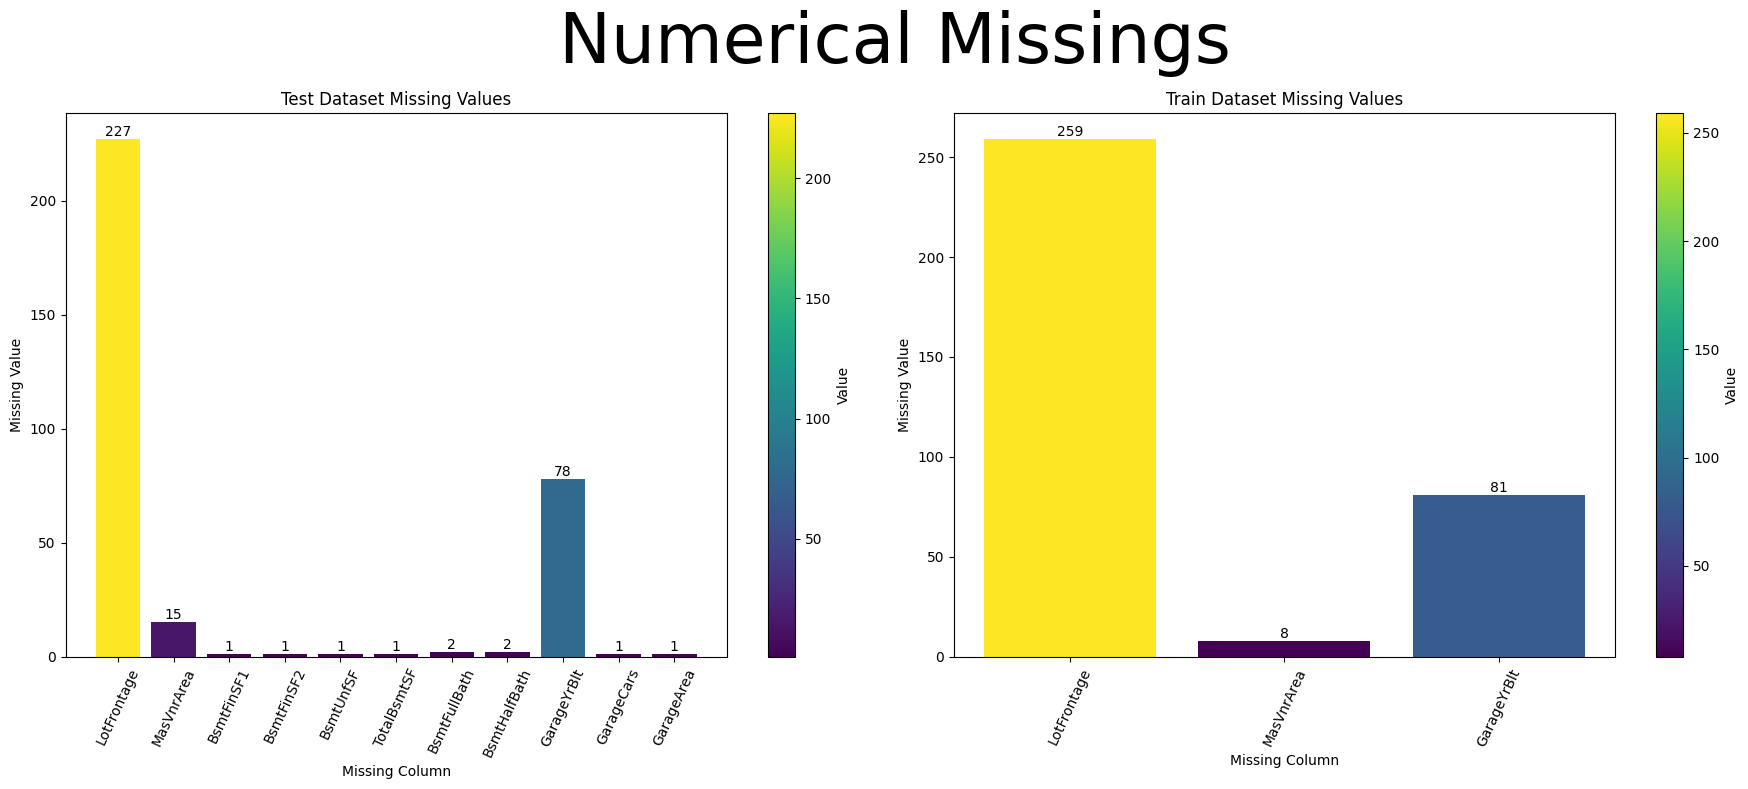

In [18]:
# Plot the training and testing missings
plot_missing_values_side_by_side(test_num_missings, train_num_missings,'Numerical')

In [19]:
# Pearson correlation (default)
num_train_samples = train_neumerical_data.shape[0]
correlation_pearson = train_neumerical_data.loc[:num_train_samples,'LotFrontage'].corr(train_neumerical_data.loc[:num_train_samples,'SalePrice'], method='pearson')
print(f"Pearson correlation: {correlation_pearson}")

Pearson correlation: 0.35179909657067804


In [20]:
# The Previous cell shows that there are a weak positive correlation between the
# SalePrice column and the LotFrontage so we will drop it
train_neumerical_data.drop('LotFrontage',axis =1,inplace=True)
test_neumerical_data.drop('LotFrontage',axis =1,inplace=True)

In [21]:
# Test the correlation of the columns GarageYrBlt to SalePrice before handling
correlation_pearson_2 = train_neumerical_data.loc[:num_train_samples,'GarageYrBlt'].corr(train_neumerical_data.loc[:num_train_samples,'SalePrice'], method='pearson')
print(f"Pearson correlation: {correlation_pearson_2}")

Pearson correlation: 0.48636167748786097


In [22]:
train_neumerical_data['GarageYrBlt'].fillna(int(train_neumerical_data['GarageYrBlt'].mean()),inplace=True)
test_neumerical_data['GarageYrBlt'].fillna(int(test_neumerical_data['GarageYrBlt'].mean()),inplace=True)

In [23]:
# Test the correlation of the columns GarageYrBlt to SalePrice after handling
correlation_pearson_3 = train_neumerical_data['GarageYrBlt'].corr(train_neumerical_data['SalePrice'], method='pearson')
print(f"Pearson correlation: {correlation_pearson_3}")

Pearson correlation: 0.47131598734440144


In [24]:
# Show the Remaining columns with missings
train_num_missings = cols_with_missings(train_neumerical_data)

test_num_missings = cols_with_missings(test_neumerical_data)

In [25]:
# Fill the Remaining missings in the Training dataset
for col in train_num_missings.index:
    train_neumerical_data[col].fillna(train_neumerical_data[col].mean(),inplace=True)

# Fill the Remaining missings in the Testing dataset
for col in test_num_missings.index:
    test_neumerical_data[col].fillna(test_neumerical_data[col].mean(),inplace=True)


**Converting the columns Contains A year into the number of years**

In [26]:
substrings = ['Yr' ,'Year']
train_years_columns = [col for col in train_neumerical_data.columns if any(substring in col for substring in substrings)]
test_years_columns = [col for col in test_neumerical_data.columns if any(substring in col for substring in substrings)]

print(f'Years columns is Training dataset are : {train_years_columns}')
print(f'Years columns is Testing dataset are : {test_years_columns}')

Years columns is Training dataset are : ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
Years columns is Testing dataset are : ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


In [27]:
train_neumerical_data.drop('YrSold',axis=1,inplace = True)
test_neumerical_data.drop('YrSold',axis=1,inplace = True)

train_years_columns.remove('YrSold')
test_years_columns.remove('YrSold')

In [28]:
# For train Dataset 
train_neumerical_data['BuiltFrom'] = 2024 - train_neumerical_data['YearBuilt']
train_neumerical_data['RemodAddFrom'] = 2024 - train_neumerical_data['YearRemodAdd']
train_neumerical_data['GarageBltFrom'] = 2024 - train_neumerical_data['GarageYrBlt']

# For test dataset
test_neumerical_data['BuiltFrom'] = 2024 - test_neumerical_data['YearBuilt']
test_neumerical_data['RemodAddFrom'] = 2024 - test_neumerical_data['YearRemodAdd']
test_neumerical_data['GarageBltFrom'] = 2024 - test_neumerical_data['GarageYrBlt']

In [29]:
# For train Dataset 
train_neumerical_data.drop('YearBuilt',axis=1,inplace = True)
train_neumerical_data.drop('YearRemodAdd',axis=1,inplace = True)
train_neumerical_data.drop('GarageYrBlt',axis=1,inplace = True)

# For train Dataset 
test_neumerical_data.drop('YearBuilt',axis=1,inplace = True)
test_neumerical_data.drop('YearRemodAdd',axis=1,inplace = True)
test_neumerical_data.drop('GarageYrBlt',axis=1,inplace = True)

In [30]:
# Drop thc column ID
train_neumerical_data.drop('Id',axis=1,inplace = True)
test_neumerical_data.drop('Id',axis=1,inplace = True)

**Select Best numerical features**

In [31]:
# Function to get the best features according to XGBOOST Regressor
def perform_rfe_with_xgboost(X, y, num_features_to_select):
    # Initialize the XGBoost Regressor
    model = XGBRegressor(objective='reg:squarederror')  # You can adjust parameters if needed
    
    # Initialize RFE with the XGBoost model
    rfe = RFE(model, n_features_to_select=num_features_to_select)
    
    # Fit RFE
    fit = rfe.fit(X, y)
    
    # Get selected features
    selected_features = X.columns[fit.support_]
    X_selected = X[selected_features]

    return X_selected, selected_features

# Example usage:
X_selected, selected_features = perform_rfe_with_xgboost(train_neumerical_data.drop('SalePrice',axis=1), train_neumerical_data['SalePrice'], num_features_to_select=10)

In [32]:
# Train data with the best 10 numerical features
train_best_num_features = train_neumerical_data[selected_features]
train_best_num_features = pd.concat([train_best_num_features,train_neumerical_data['SalePrice']],axis=1)

# Test data with the best 10 numerical features
test_best_num_features = test_neumerical_data[selected_features]

In [33]:
# The Correlation between the selected features and the target
corrWithPrice = train_best_num_features.iloc[:,:].corrwith(train_best_num_features.SalePrice)
corrWithPrice

OverallQual     0.790982
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
KitchenAbvGr   -0.135907
Fireplaces      0.466929
GarageCars      0.640409
SalePrice       1.000000
dtype: float64

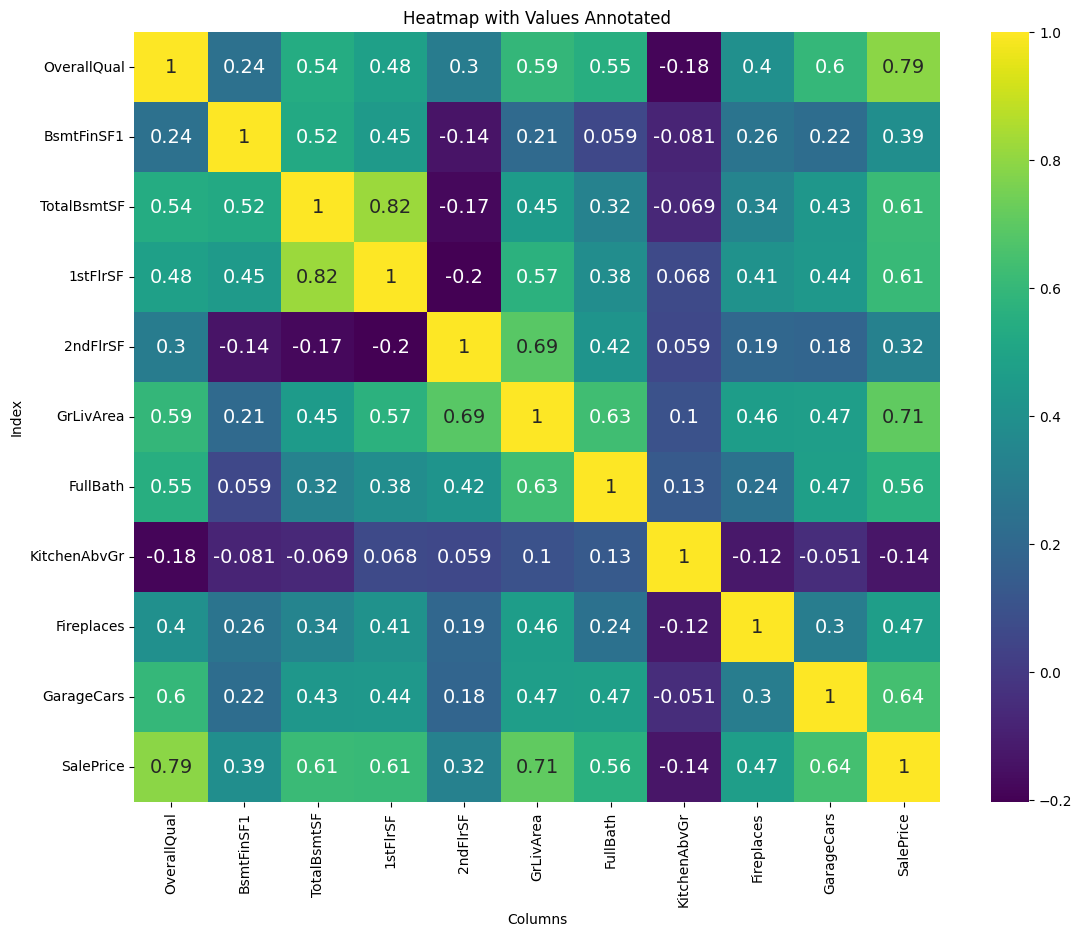

In [34]:
numCorr = train_best_num_features.corr()

plt.figure(figsize=(13, 10))
sns.heatmap(numCorr, annot=True, cmap="viridis", annot_kws={"size": 14})

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Index')
plt.title('Heatmap with Values Annotated')

# Display the heatmap
plt.show()

In [35]:
# Save the Training and Testing dataset
train_best_num_features.to_csv('train_processed_data.csv',index=False)
test_best_num_features.to_csv('test_processed_data.csv',index=False)

**Rescaling The Data**

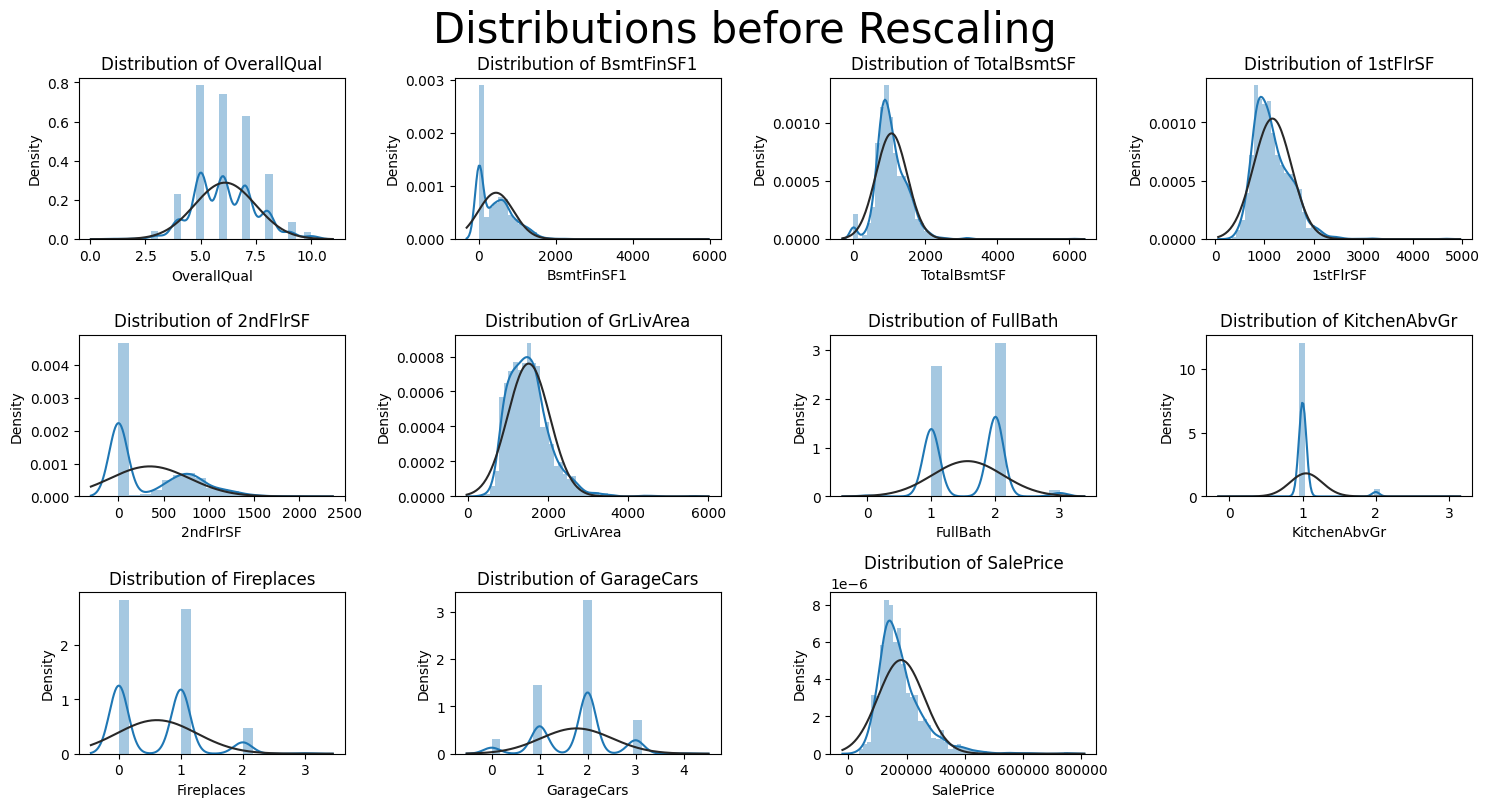

In [36]:
# Set up the matplotlib figure with a grid of 3x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(15, 13))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a distplot for each column
for i, column in enumerate(train_best_num_features.columns):
    sns.distplot(train_best_num_features[column], kde=True,fit=norm, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Remove any unused subplots
for j in range(len(train_best_num_features.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle('Distributions before Rescaling',fontsize=30)
plt.tight_layout()
plt.show()

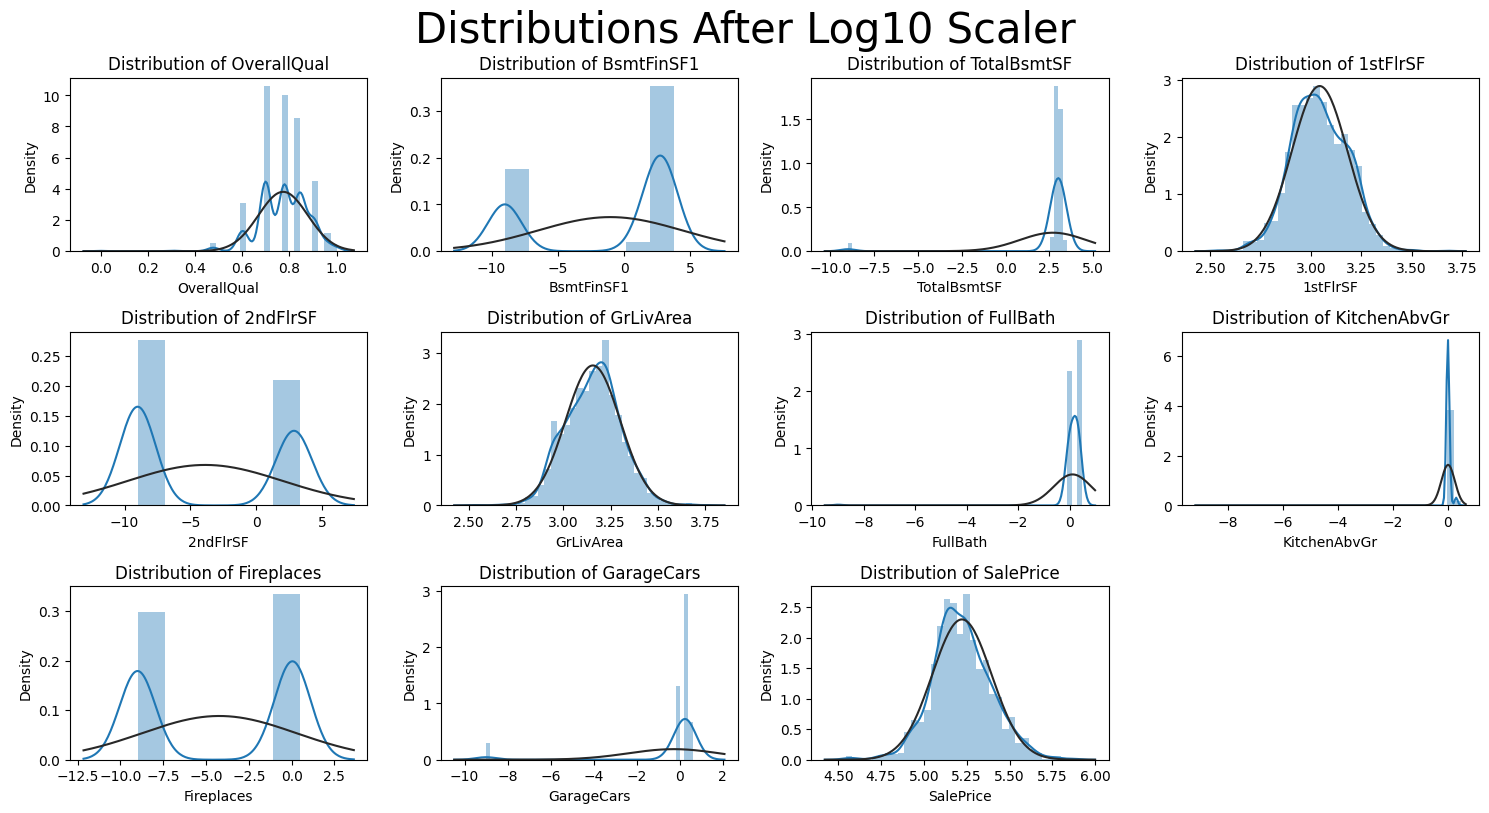

In [37]:
# Apply log10
Logged_trainNumData = np.log10(train_best_num_features + 1e-9)  # adding 1e-9 to handle zeros values
Logged_testNumData = np.log10(test_best_num_features + 1e-9)  # adding 1e-9 to handle zeros values

# Set up the matplotlib figure with a grid of 5x4 subplots
fig, axes = plt.subplots(5, 4, figsize=(15, 13))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create a distplot for each column
for i, column in enumerate(Logged_trainNumData.columns):
    sns.distplot(Logged_trainNumData[column], kde=True, fit=norm, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Remove any unused subplots
for j in range(len(Logged_trainNumData.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle('Distributions After Log10 Scaler', fontsize=30)
plt.tight_layout()
plt.show()

**Handling the Outliars**

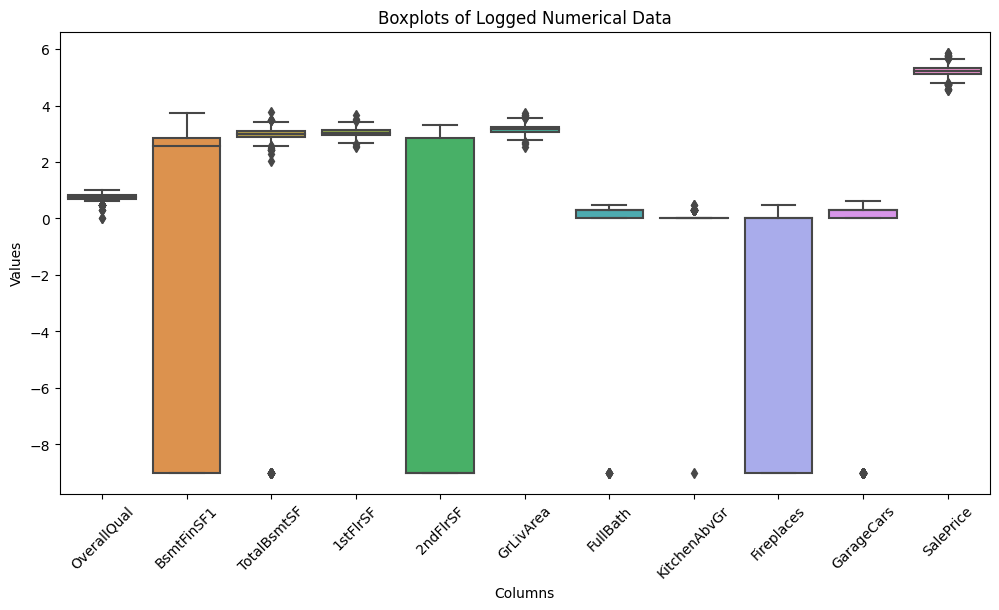

In [38]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create boxplots for each column
sns.boxplot(data=Logged_trainNumData, orient='v')

# Add title and labels
plt.title('Boxplots of Logged Numerical Data')
plt.xticks(rotation=45)
plt.xlabel('Columns')
plt.ylabel('Values')

# Display the boxplot
plt.show()

In [39]:
# Calculate IQR for each column
Q1 = Logged_trainNumData.quantile(0.25)
Q3 = Logged_trainNumData.quantile(0.75)
IQR = Q3 - Q1
IQR

OverallQual      0.146128
BsmtFinSF1      11.852632
TotalBsmtSF      0.212582
1stFlrSF         0.197937
2ndFlrSF        11.862131
GrLivArea        0.196740
FullBath         0.301030
KitchenAbvGr     0.000000
Fireplaces       9.000000
GarageCars       0.301030
SalePrice        0.216554
dtype: float64

In [40]:
# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [41]:
# Replace outliers greater than max with max and outliers smaller than min with min
for column in Logged_trainNumData.columns:
    Logged_trainNumData[column] = Logged_trainNumData[column].mask(Logged_trainNumData[column] > upper_bound[column], upper_bound[column])
    Logged_trainNumData[column] = Logged_trainNumData[column].mask(Logged_trainNumData[column] < lower_bound[column], lower_bound[column])

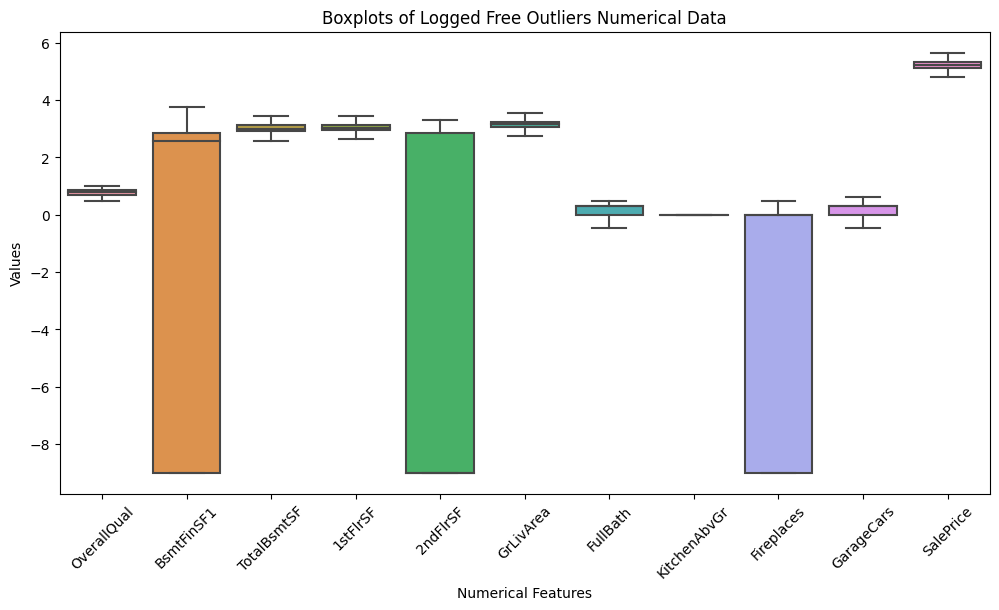

In [42]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create boxplots for each column
sns.boxplot(data=Logged_trainNumData, orient='v')

# Add title and labels
plt.title('Boxplots of Logged Free Outliers Numerical Data')
plt.xticks(rotation=45)
plt.xlabel('Numerical Features')
plt.ylabel('Values')

# Display the boxplot
plt.show()

**Dealing with categorical data**

In [44]:
train_obj_data = train_data[train_object_columns]
test_obj_data = test_data[test_object_columns]

**Handelling Categorical Missing values**

In [52]:
train_obj_missings = cols_with_missings(train_obj_data)
test_obj_missings = cols_with_missings(test_obj_data)

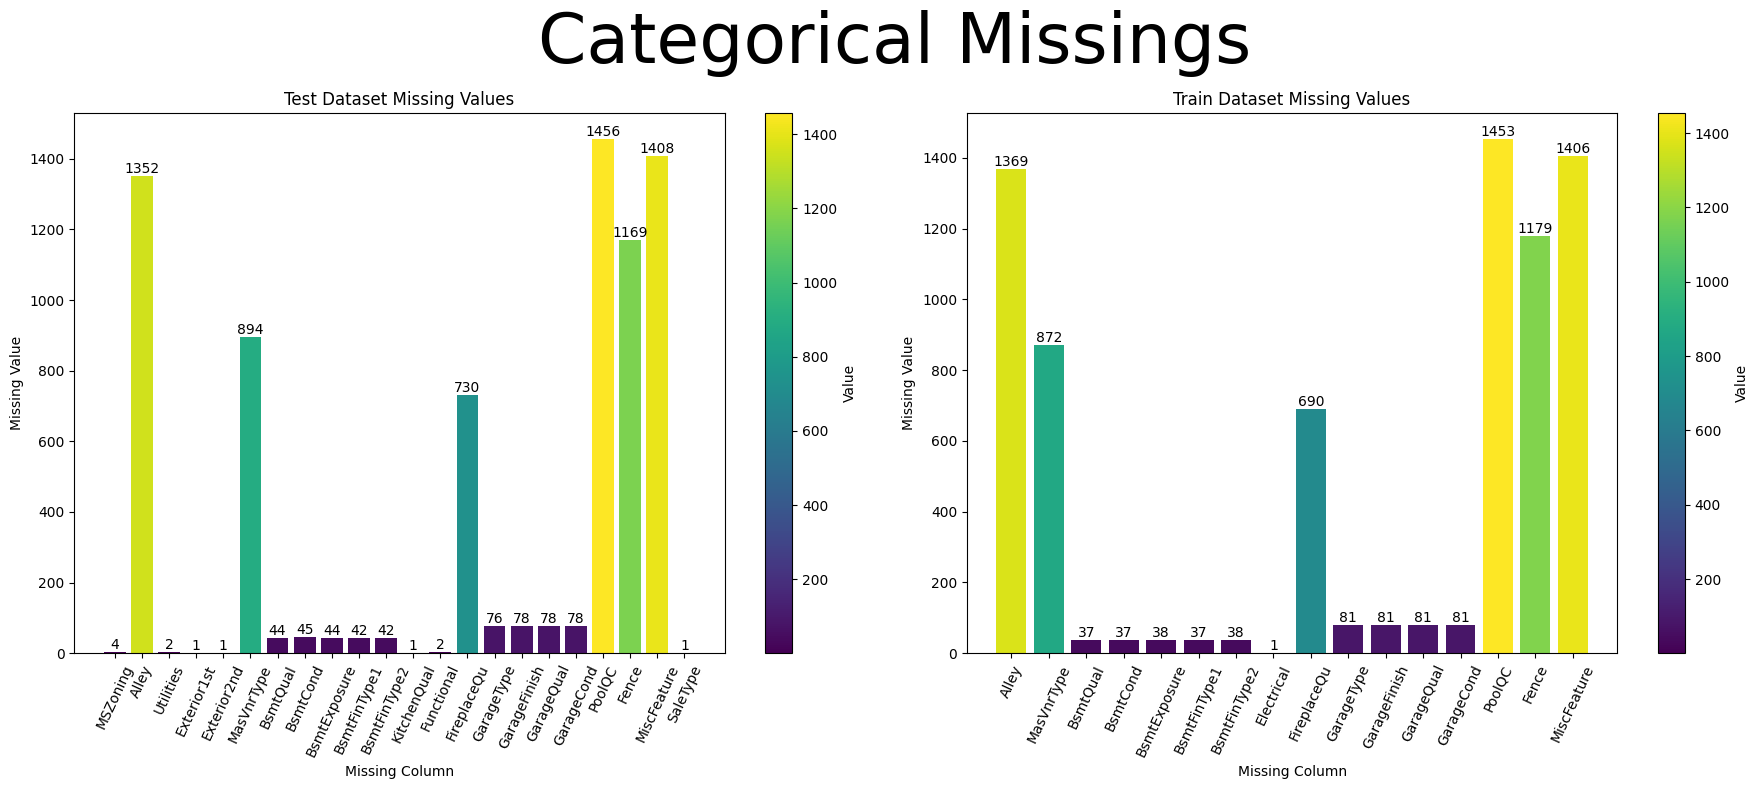

In [55]:
# Plot the training and testing Categorical missings
plot_missing_values_side_by_side(test_obj_missings,train_obj_missings,'Categorical')

In [65]:
# Dropping the columns with more than 40% missing values
train_obj_cols_to_drop = train_obj_missings[train_obj_missings/num_train_samples > 0.4].index
test_obj_cols_to_drop = test_obj_missings[test_obj_missings/num_train_samples > 0.4].index

In [77]:
# Check that the columns with the highest missings are the same at both the datasets 
ck = all(train_obj_cols_to_drop == test_obj_cols_to_drop)
obj_cols_to_drop = []
if ck:
    obj_cols_to_drop = train_obj_cols_to_drop
    print(f'The Datasets have missings in columns : {list(obj_cols_to_drop)}')
else:
    print('There are different columns to drop!\nPlease Check the dataset')

The Datasets have missings in columns : ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [78]:
# Drop the columns 
train_obj_data.drop(obj_cols_to_drop,axis=1,inplace=True)
test_obj_data.drop(obj_cols_to_drop,axis=1,inplace=True)

In [83]:
# Counting the remaining missings
train_obj_missings = cols_with_missings(train_obj_data)
test_obj_missings = cols_with_missings(test_obj_data)

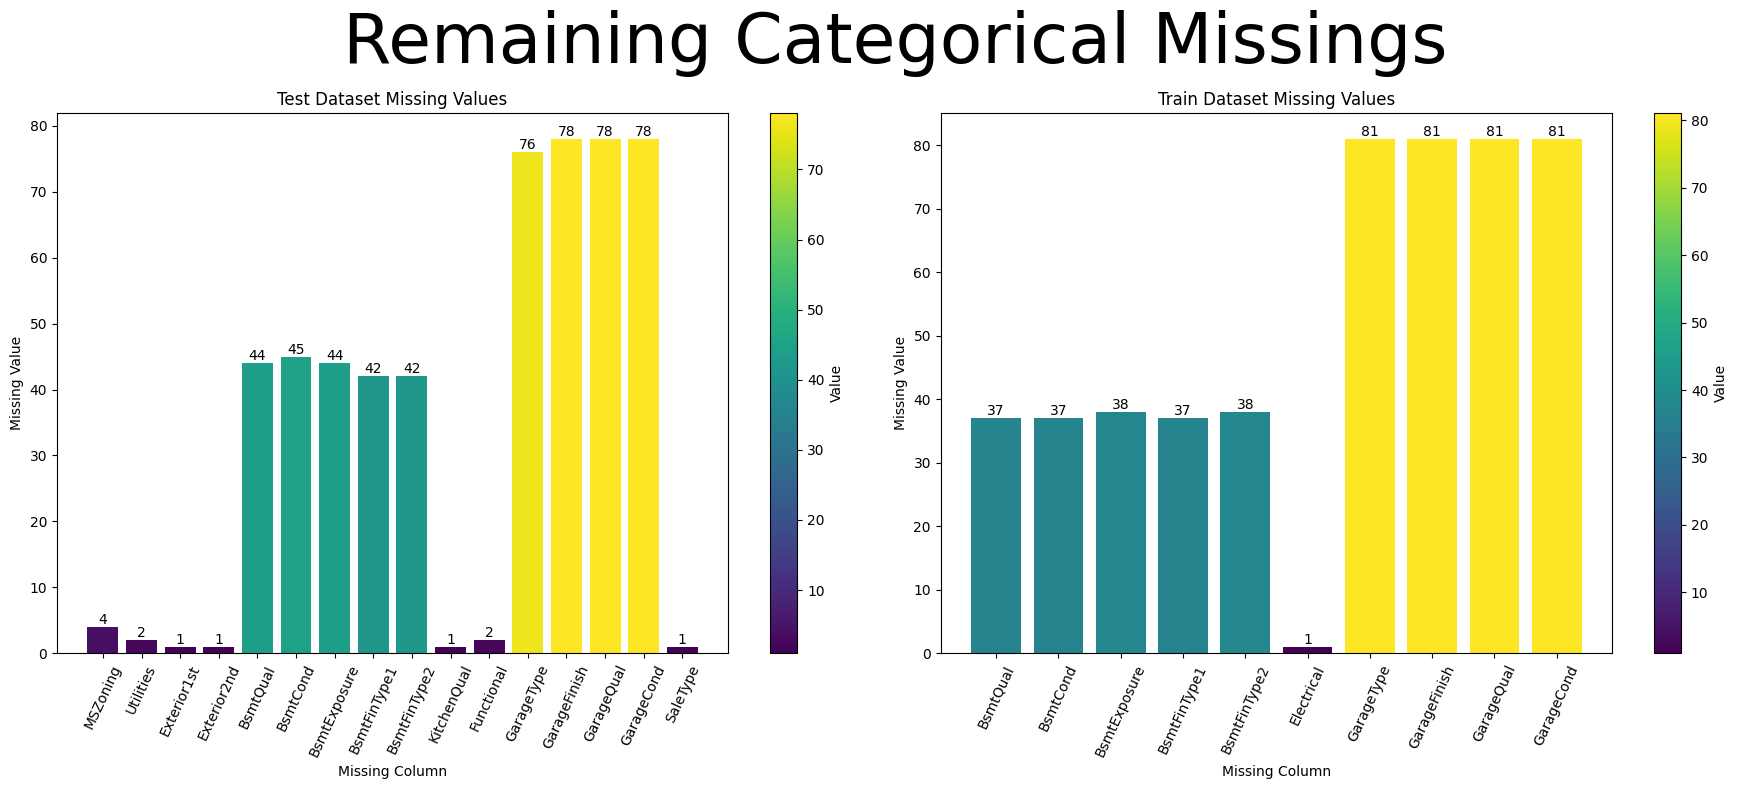

In [85]:
# Plot the training and testing Categorical missings
plot_missing_values_side_by_side(test_obj_missings,train_obj_missings,'Remaining Categorical')

In [87]:
# Replacing the Missing values with the mode() for each column
# Filling the Training dataset
for col in train_obj_missings.index:
    train_obj_data[col].fillna(train_obj_data[col].mode()[0],inplace=True)

# Filling the Testing dataset
for col in test_obj_missings.index:
    test_obj_data[col].fillna(test_obj_data[col].mode()[0],inplace=True)

In [91]:
train_obj_data

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


In [94]:
# Function to plot the categorical data frequancies
def plot_categorical_frequencies(df, columns=None, max_columns_per_row=3, figsize_per_plot=(5, 5)):
    # If no specific columns are provided, use all categorical columns
    if columns is None:
        columns = df.select_dtypes(include=['object']).columns
    
    num_columns = len(columns)
    num_rows = (num_columns + max_columns_per_row - 1) // max_columns_per_row  # Adjust rows based on number of columns

    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, max_columns_per_row, figsize=(figsize_per_plot[0] * max_columns_per_row, num_rows * figsize_per_plot[1]))
    axes = axes.flatten()

    # Create a bar plot for each categorical column
    for i, column in enumerate(columns):
        ax = sns.countplot(data=df, x=column, ax=axes[i])
        axes[i].set_title(f'Frequency of {column}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
        
        # Add value labels on the bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2.0, 
                height, 
                '{:1.0f}'.format(height), 
                ha="center", va="bottom"
            )
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()



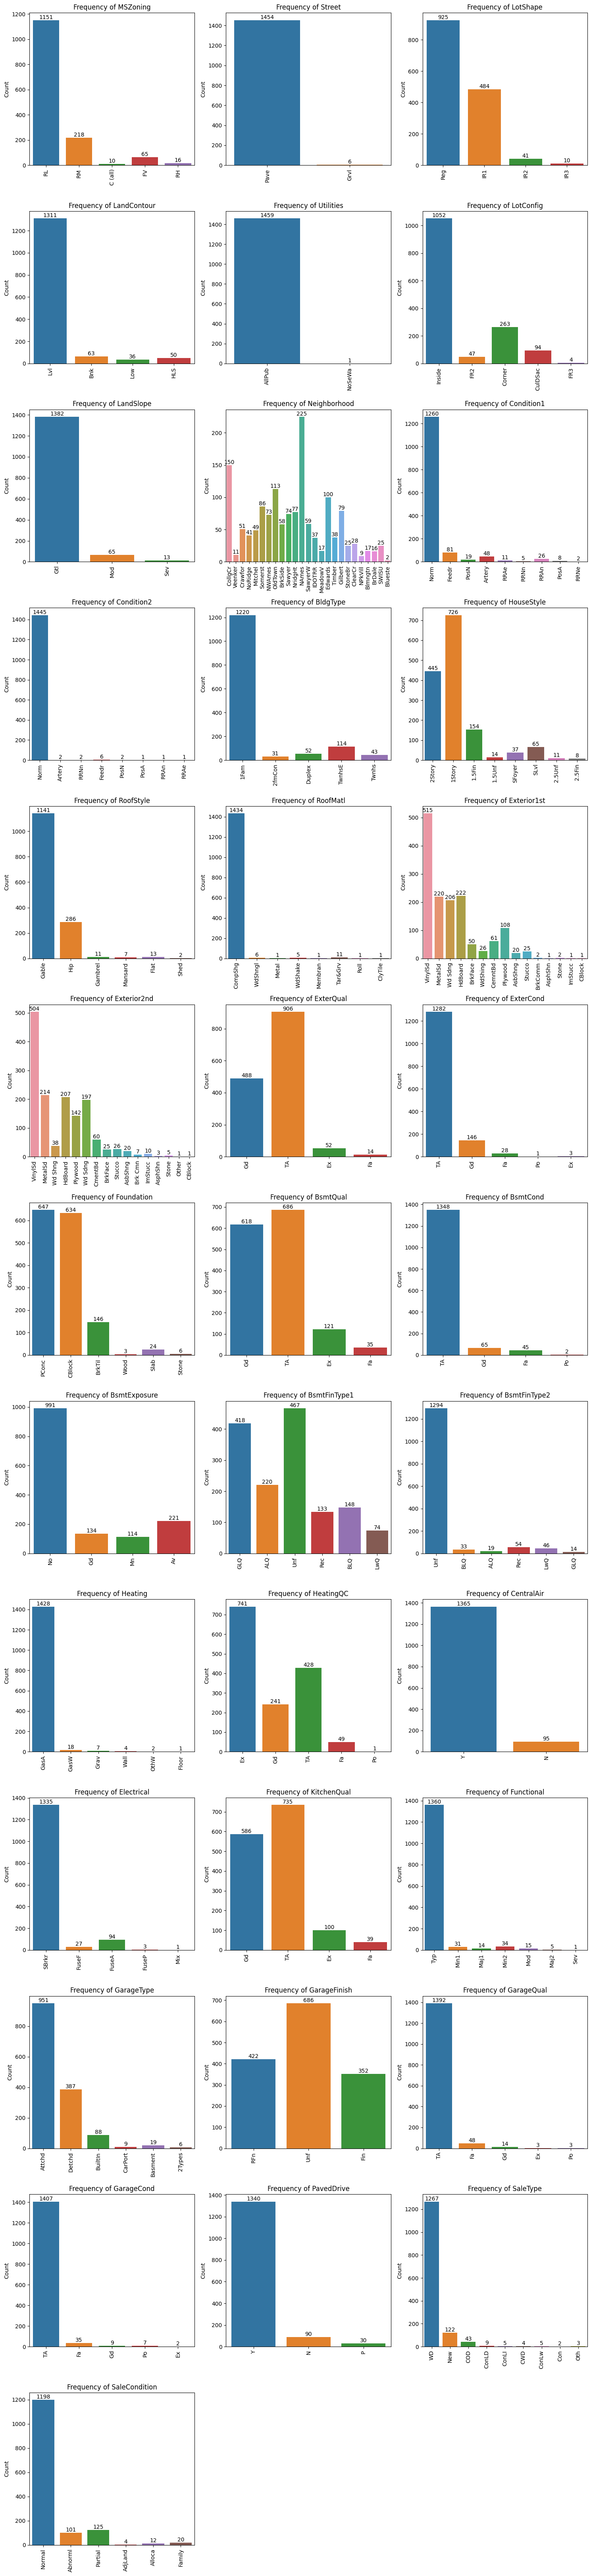

In [95]:
plot_categorical_frequencies(train_obj_data)

In [99]:
target = Logged_trainNumData.SalePrice

**Encoding and Selecting Features From the datasets**

In [111]:
# One-Hot Encode the categorical data
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_train_cat_data = encoder.fit_transform(train_obj_data)
encoded_test_cat_data = encoder.transform(test_obj_data)


# Convert the encoded data back to a DataFrame for easier handling
encoded_train_cat_data = pd.DataFrame(encoded_train_cat_data, columns=encoder.get_feature_names_out(train_obj_data.columns))
encoded_test_cat_data = pd.DataFrame(encoded_test_cat_data, columns=encoder.get_feature_names_out(test_obj_data.columns))

# Ensure the index is aligned with the original data
encoded_train_cat_data.index = train_obj_data.index
encoded_test_cat_data.index = test_obj_data.index


In [114]:
# Define the best features according to the XGBoost Regressor
# Define the target variable
y = target

# Initialize and train the XGBoost Regressor
model = XGBRegressor()
model.fit(encoded_cat_df, y)

# Extract feature importances
feature_importances = pd.Series(model.feature_importances_, index=encoded_cat_df.columns)

# Sort the feature importances
feature_importances = feature_importances.sort_values(ascending=False)

# Select the top features (you can specify how many top features to select)
top_features = feature_importances.head(10).index.tolist()  

# Print the selected features and their importance scores
print("Top Selected Features:\n", top_features)
print("\nFeature Importances:\n", feature_importances[:10])


Top Selected Features:
 ['ExterQual_TA', 'ExterQual_Fa', 'GarageFinish_Unf', 'RoofStyle_Hip', 'CentralAir_Y', 'BsmtQual_TA', 'Neighborhood_NoRidge', 'Neighborhood_ClearCr', 'Heating_GasA', 'BsmtQual_Gd']

Feature Importances:
 ExterQual_TA            0.297846
ExterQual_Fa            0.135136
GarageFinish_Unf        0.048699
RoofStyle_Hip           0.035586
CentralAir_Y            0.031479
BsmtQual_TA             0.030359
Neighborhood_NoRidge    0.021204
Neighborhood_ClearCr    0.017480
Heating_GasA            0.013760
BsmtQual_Gd             0.013560
dtype: float32


In [118]:
# Select the best features using SelectKBest
def select_best_features_kbest(X, y, k):
   
    # Initialize SelectKBest with f_regression as the scoring function
    kbest = SelectKBest(score_func=f_regression, k=k)
    
    # Fit SelectKBest on the data
    kbest.fit(X, y)
    
    # Get the selected features
    selected_columns = X.columns[kbest.get_support()]
    X_selected = X[selected_columns]

    return X_selected, selected_columns

# Example usage:
# Assume target is your target variable
k = 10  # Choose the number of features you want to select
X_selected, kbest_selected_features = select_best_features_kbest(encoded_train_cat_data, target, k)

# Print the selected features
print("Selected Features:\n", kbest_selected_features)


Selected Features:
 Index(['Neighborhood_NridgHt', 'ExterQual_Gd', 'ExterQual_TA',
       'Foundation_PConc', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'KitchenQual_Gd',
       'KitchenQual_TA', 'GarageType_Detchd', 'GarageFinish_Unf'],
      dtype='object')


In [128]:
# Get the Best Features Selected from both techniques
best_cat_features_combined = np.unique(list(kbest_selected_features)+top_features)
best_cat_features_combined

array(['BsmtFinType1_GLQ', 'BsmtQual_Gd', 'BsmtQual_TA', 'CentralAir_Y',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc',
       'GarageFinish_Unf', 'GarageType_Detchd', 'Heating_GasA',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Neighborhood_ClearCr',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'RoofStyle_Hip'],
      dtype='<U20')

In [129]:
best_cat_features_combined

array(['BsmtFinType1_GLQ', 'BsmtQual_Gd', 'BsmtQual_TA', 'CentralAir_Y',
       'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_PConc',
       'GarageFinish_Unf', 'GarageType_Detchd', 'Heating_GasA',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Neighborhood_ClearCr',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'RoofStyle_Hip'],
      dtype='<U20')

In [132]:
encoded_train_cat_data = encoded_train_cat_data[best_cat_features_combined]
encoded_test_cat_data = encoded_test_cat_data[best_cat_features_combined]

In [ ]:
# # Get a list contains the columns name which contain a value with frequents more than 1000

# # List to store column names with any value count greater than 2000
# columns_with_large_counts = []

# # Check each categorical column
# for column in object_data.columns:
#     value_counts = object_data[column].value_counts()
#     if any(value_counts > 1000):
#         columns_with_large_counts.append(column)

        
# columns_with_large_counts

In [ ]:
# # Drop this columns
# object_data.drop(columns_with_large_counts,axis=1,inplace=True)

In [ ]:
# object_data

In [ ]:
# # Apply one-hot encoding
# object_encoded = pd.get_dummies(object_data, columns=object_data.columns, drop_first=True)

In [ ]:
# object_encoded

In [ ]:
# # Split The categorical train and test data
# trainObjData = object_encoded.iloc[:1460,:]
# testObjData = object_encoded.iloc[1460:,:].reset_index(drop=True)
# testObjData.to_csv('test_obj_data.csv',index=False)

# Prepare the Model

In [136]:
processed_train_data = pd.concat([Logged_trainNumData,encoded_train_cat_data],axis = 1)
processed_test_data = pd.concat([Logged_testNumData,encoded_test_cat_data],axis = 1)

**Splitting the train data into train and test to train and evaluate models**

In [139]:
from sklearn.model_selection import train_test_split

X_train = processed_train_data.drop('SalePrice',axis = 1)
y_train = processed_train_data.loc[:,'SalePrice']
X_test = processed_test_data

# X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# Display the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

X_train shape: (1460, 27)
X_test shape: (1459, 27)
y_train shape: (1460,)


**Train XGBoost Regressor Model**

In [142]:
# Initialize the XGBoost Regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Define the loss function for regression
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Learning rate
    max_depth=6,                   # Maximum depth of a tree
    subsample=0.8,                 # Fraction of samples used per tree
    colsample_bytree=0.8,          # Fraction of features used per tree
    random_state=42                # Ensures reproducibility
)

# Train the model on the training data
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [148]:
# Make predictions on the test data
y_pred = xgboost_model.predict(X_test)
y_pred = 10 ** y_pred

# # Evaluate the model's performance using Mean Squared Error
# mse = mean_squared_error(y_train, y_pred)
# print(f"Mean Squared Error: {mse}")

# # Optionally, you can print the Root Mean Squared Error
# rmse = mse ** 0.5
# print(f"Root Mean Squared Error: {rmse}")


In [149]:
sample_submession = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submession['SalePrice'] = y_pred
sample_submession

,Id,SalePrice
0,1461,122789.007812
1,1462,151230.484375
2,1463,179955.484375
3,1464,186488.812500
4,1465,194845.765625
...,...,...
1454,2915,74859.359375
1455,2916,81758.570312
1456,2917,140804.125000
1457,2918,104353.609375


In [150]:
sample_submession.to_csv('my_submession1.csv',index=False)